In [ ]:
import torch
import numpy as np
import random
import pandas as pd

def fixSeeds():
  # To make random weights in NN consistent from launch to launch on this device
  # To actually distinguish an improvement
  random.seed(0)
  np.random.seed(0)
  torch.manual_seed(0)
  torch.cuda.manual_seed(0)
  torch.backends.cudnn.deterministic = True

fixSeeds()

In [ ]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [ ]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

X_train.dtype, y_train.dtype

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


(torch.uint8, torch.int64)

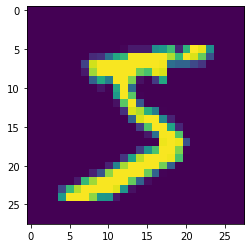

tensor(5)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
y_train[0]

In [ ]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()


In [ ]:
X_train.shape, X_test.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

In [ ]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Wed Dec 29 08:54:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    79W / 149W |   1820MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch.nn as nn
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    
    self.conv1 = nn.Conv2d(
        in_channels=1, out_channels=12, kernel_size=5, padding=2)
    self.act1 = nn.Tanh()
    self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(
        in_channels=12, out_channels=36, kernel_size=5, padding=0)
    self.act2 = nn.Tanh()
    self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(36*5*5, 120)
    self.act3 = nn.Tanh()

    self.fc2 = nn.Linear(120, 84)
    self.act4 = nn.Tanh()

    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.act2(x)
    x = self.pool2(x)

    x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

    x = self.fc1(x)
    x = self.act3(x)

    x = self.fc2(x)
    x = self.act4(x)

    x = self.fc3(x)

    return x
leNet5 = LeNet5()
leNet5.to(device)

LeNet5(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): Tanh()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(12, 36, kernel_size=(5, 5), stride=(1, 1))
  (act2): Tanh()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=900, out_features=120, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (act4): Tanh()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(leNet5.parameters(), lr = 1e-3)

In [ ]:
batch_size = 100

X_test = X_test.to(device)
y_test = y_test.to(device)


test_accuracy_history = []
test_loss_history = []

for epoch in range(200):
  permutation = np.random.permutation(len(X_train))
  for start_index in range(0, len(X_train), batch_size):
    optimizer.zero_grad()

    X_batch = X_train[permutation[start_index : start_index + batch_size]].to(device)
    y_batch = y_train[permutation[start_index : start_index + batch_size]].to(device)
    
    prediction = leNet5.forward(X_batch)
    loss_value = loss(prediction, y_batch)
    loss_value.backward()

    optimizer.step()

  test_prediction = leNet5.forward(X_test)
  test_loss_history.append(loss(test_prediction, y_test).data.cpu())
  accuracy = (test_prediction.argmax(dim=1) == y_test).float().mean().data.cpu()
  test_accuracy_history.append(accuracy)
  print(accuracy)



tensor(0.9838)
tensor(0.9832)
tensor(0.9868)
tensor(0.9863)
tensor(0.9893)
tensor(0.9897)
tensor(0.9882)
tensor(0.9896)
tensor(0.9892)
tensor(0.9872)
tensor(0.9890)
tensor(0.9869)
tensor(0.9884)
tensor(0.9890)
tensor(0.9887)
tensor(0.9875)
tensor(0.9894)
tensor(0.9903)
tensor(0.9904)
tensor(0.9886)
tensor(0.9895)
tensor(0.9895)
tensor(0.9906)
tensor(0.9907)
tensor(0.9885)
tensor(0.9886)
tensor(0.9892)
tensor(0.9892)
tensor(0.9904)
tensor(0.9883)
tensor(0.9889)
tensor(0.9908)
tensor(0.9895)
tensor(0.9892)
tensor(0.9894)
tensor(0.9905)
tensor(0.9884)
tensor(0.9916)
tensor(0.9895)
tensor(0.9893)
tensor(0.9885)
tensor(0.9901)
tensor(0.9898)
tensor(0.9894)
tensor(0.9888)
tensor(0.9892)
tensor(0.9876)
tensor(0.9886)
tensor(0.9904)
tensor(0.9896)
tensor(0.9883)
tensor(0.9900)
tensor(0.9892)
tensor(0.9890)
tensor(0.9883)
tensor(0.9895)
tensor(0.9902)
tensor(0.9898)
tensor(0.9890)
tensor(0.9886)
tensor(0.9899)
tensor(0.9897)
tensor(0.9904)
tensor(0.9876)
tensor(0.9889)
tensor(0.9900)
tensor(0.9

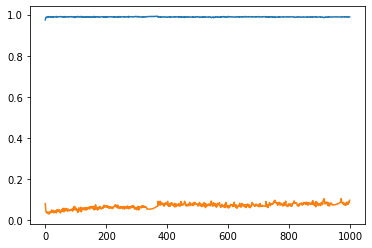

In [ ]:
plt.plot(test_accuracy_history);
plt.plot(test_loss_history);